# How to use `random_mountain`

In [1]:
import sys
sys.path.append('../')

import CreativeQiskit

In this tool we imagine the $2^n$ possible bitstrings for $n$ qubits as a set of positions. For each, we will then imagine the probability for that bitstring as the height of a mountain at that position. Then our qubits can be interpreted as giving us a mountain range.

Unfortunately, getting a sensible mountain range is not quite so simple.

Most of the operations we apply in a quantum program act on only one or two qubits. If we start with a state like `000000...`, it therefore takes only one operation to get to `100000...` but many to get to `111111...`. The 'distance' between bit strings is therefore well described by the 'Hamming distance', which is the number of bits from one that disagree with the corresponding bit from the other.

For our mountain range, we have a position associated with each bitstring. It is most natural to try to lay these out such that they are separated by the corresponding Hamming distance. For a single qubit, this is easy: two points on a line. For two qubits we have four points in a square. For three we need a cube. For four, we need a tesseract!

In general, for $n$ qubits, the points will be the corners of a $2^n$ dimensional hypercube. Our mountains will point out into the $(2^n+1)$th dimension. So not very easy to visualize!

To solve this problem we will squash the points down onto a plane and get a corresponding set of coordinates. With the heights, we then have our mountain range. Two methods are provided to do this, which can be specificied with the `methods` kwarg of the `get_mountain()` method.

The default is `'square'`, which squashes the hypercube down to a square lattice. This is done such that neighbours of each point in the lattice are neighbours from the hypercube.

The other method is `'rings'`, which places the point with the highest probability in the center, and then arranges the rest around randomly with a distance equal to their Hamming distance.

We'll use a class to generate our random mountain ranges. To set this up, we just need to specify the number of qubits. This determines the resolution of our mountain range: for n qubits we'll have $2^n$ points.

In [2]:
n = 2
alps = CreativeQiskit.random_mountain(n)

The mountain range is extracted using `get_mountain()`.

In [3]:
pos,prob = alps.get_mountain()
print('coordinates\n',pos)
print('\nprobabilities\n',prob)

coordinates
 {'11': (0, 0), '10': (1, 0), '01': (0, 1), '00': (1, 1)}

probabilities
 {'00': 1.0, '11': 0.0625, '10': 0.0625, '01': 0.0625}


In the above example, all the height is concentrated on the bitstring `00`. This is because the quantum circuit for n qubits starts with the n-bit string of all `0`s. If we don't add anything to the circuit, that's the only result we'll get at readout.

The quantum circuit and the register of n qubits that generate the mountain range are attributes of the `random_mountain` object. So we can use them add operations to our circuit, and make our mountain range more interesting than just a single sharp peak.

Let's try this out with a few more qubits.

In [4]:
n = 8
alps = CreativeQiskit.random_mountain(n)
alps.qc.h(alps.qr[0])

pos,prob = alps.get_mountain()

Here the `h` operation is used on the first qubit (which, with the convention Qiskit uses, is on the right end of the string). This will create a superposition of `0` and `1` on that qubit, and hence give an outcome that is randomly split between `0000` and `0001`.

Let's visualize this with a simple plot. This imagines it as an island and gives us a top-down view where you can set the sea level, tree line and snowline.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import random

def plot_mountain(pos,prob,levels=[0.3,0.8,0.9],log=True,perturb=0.0):
    [sea,tree,snow] = levels
    coords = []
    Z = []
    for node in pos:
        coords.append( [pos[node][0]+(1-random.random())*perturb,pos[node][1]+(1-random.random())*perturb] )
        if log:
            Z.append(np.log(prob[node]))
        else:
            Z.append(prob[node])
    
    vor = Voronoi(coords)
        
    minZ = min(Z)
    maxZ = max(Z)
    # normalize chosen colormap
    colors = []
    for node in range(len(Z)):
        z = (Z[node]-minZ)/(maxZ-minZ)
        if levels:
            if z<sea:
                color = (0,0.5,1,1)
            elif z<tree:
                color = (1*(z-sea),1*(1-sea),1*(z-sea),1)
            elif z<snow:
                color = (0.7,0.7,0.7,1)
            else:
                color = (1,1,1,1)
        else:
            color = (z,z,z,1)
        colors.append(color)

    # plot Voronoi diagram, and fill finite regions with color mapped from speed value
    voronoi_plot_2d(vor, show_points=True, show_vertices=False, point_size=0, line_width=0.0)
    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=colors[r])
    plt.savefig('outputs/islands.png',dpi=1000)
    plt.show()

Since these two bit strings are very closely located (a Hamming distance of 1) we get a double peaked mountain. But the surrounding land is still very flat. To add some foothills, we can use noise. The `get_mountain()` method has the standard kwargs `device`, `noisy` and `shots` as explained in [the README](README.md).

Note that, for a large number of qubits a large value of `shots` will also be needed for good resolution. By default `shots` is set to $2^{2n}$, but note that IBMQ backends can only take up to 8192 shots.

First, let's use a simple error model that we can specify by supplying the noise strength.

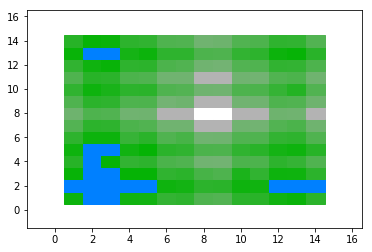

In [6]:
pos,prob = alps.get_mountain(noisy=0.3)
plot_mountain(pos,prob)

Now let's use the noise model created from today's measurements of the a real prototype 16 qubit device.

You are using an IBMQ backend. The results for this are provided in accordance with the IBM Q Experience EULA.
https://quantumexperience.ng.bluemix.net/qx/terms


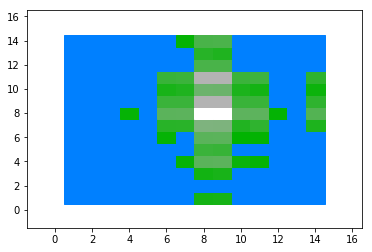

In [7]:
from qiskit import IBMQ
IBMQ.load_accounts()

pos,prob = alps.get_mountain(noisy='ibmq_16_melbourne')
plot_mountain(pos,prob)

Here's the same, but done instead with `method='rings'`.

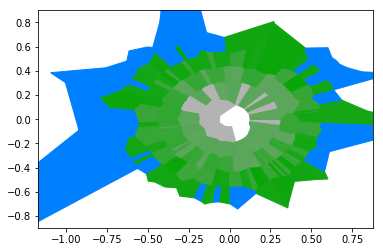

In [8]:
pos,prob = alps.get_mountain(noisy=0.3,method='rings')
plot_mountain(pos,prob,levels=[0.35,0.8,0.9])

This method randomly assigns the coordinates. To redo this, but keep the same data use the kwarg `new_data=False`.

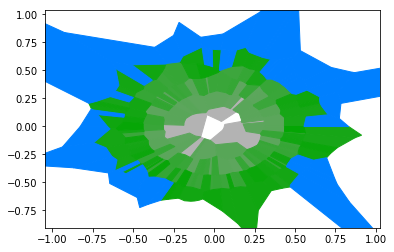

In [9]:
pos,prob = alps.get_mountain(method='rings',new_data=False)
plot_mountain(pos,prob,levels=[0.35,0.8,0.9])

With a chain of `cx` gates we can spread the superposition over all the qubits, creating a so-called GHZ state that will lead to outputs of `0000` and `1111`.

In [10]:
for j in range(n-1):
    alps.qc.cx(alps.qr[j],alps.qr[j+1])

This will give us a pair of well-separated peaks (again with the default method).

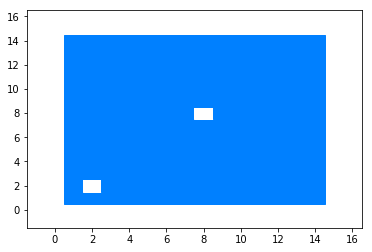

In [11]:
pos,prob = alps.get_mountain()
plot_mountain(pos,prob)

Again, these will look better with some noisy foothills.

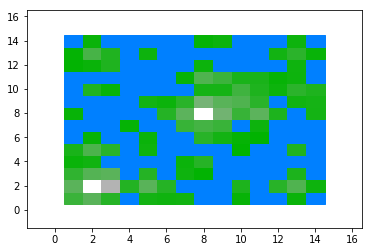

In [12]:
pos,prob = alps.get_mountain(noisy=0.3)
plot_mountain(pos,prob)

We can also peturb the positions slightly to get something that's not quite so square.

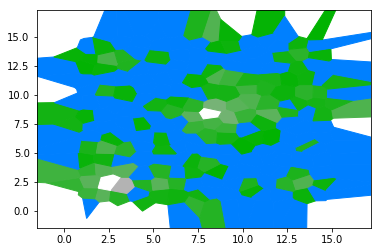

In [13]:
plot_mountain(pos,prob,perturb=0.75)

Try out other quantum programs, with and without noise, and see what mountains they give you.